In [1]:
from scipy import stats
from numpy.random import binomial
from numpy.random import normal

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import ttest_ind, ttest_rel
from scipy.stats import t, norm

In [2]:
df = pd.read_csv('data/data_ab.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2025-01-21 22:11:48.556739,control,old_page,0
1,804228,2025-01-12 08:01:45.159739,control,old_page,0
2,661590,2025-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2025-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2025-01-21 01:52:26.210827,control,old_page,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [4]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [5]:
print("Уникальные значения в 'group':", df['group'].unique())
print("Уникальные значения в 'landing_page':", df['landing_page'].unique())
print("Уникальные значения в 'converted':", df['converted'].unique())
df.duplicated('user_id').sum()

Уникальные значения в 'group': ['control' 'treatment']
Уникальные значения в 'landing_page': ['old_page' 'new_page']
Уникальные значения в 'converted': [0 1]


np.int64(3894)

# Проверка замысла A/B теста:
* ## Группа A (control + old_page):
  *  `group` = `control`

  *  `landing_page` = `old_page`

* ## Группа B (treatment + new_page):
  *  `group` = `treatment`

  *  `landing_page` = `new_page`

In [6]:

print("Всего строк:", len(df))
print(df['group'].value_counts())
print(df['landing_page'].value_counts())
cross = pd.crosstab(df['group'], df['landing_page'])
cross

Всего строк: 294478
group
treatment    147276
control      147202
Name: count, dtype: int64
landing_page
old_page    147239
new_page    147239
Name: count, dtype: int64


landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


In [7]:
control_old = cross.loc['control', 'old_page']
control_new = cross.loc['control', 'new_page']
treatment_old = cross.loc['treatment', 'old_page']
treatment_new = cross.loc['treatment', 'new_page']

print(f"Control + Old: {control_old}")
print(f"Control + New: {control_new}")
print(f"Treatment + Old: {treatment_old}")
print(f"Treatment + New: {treatment_new}")

print(f"Ошибочных кимбинаций: {control_new + treatment_old}, {(control_new + treatment_old)/len(df)*100:.2f}%")

Control + Old: 145274
Control + New: 1928
Treatment + Old: 1965
Treatment + New: 145311
Ошибочных кимбинаций: 3893, 1.32%


Обнаружено 3893 пользователей (1.3%), у которых показанная версия страницы не совпадала с назначенной группой. Данные пользователя с ошибочной комбинацией (control+new_page или treatment+old_page) исключены из анализа, так как нарушают протокол эксперимента и могут искажать итоговый эффект.


In [8]:
df_clean = df[((df['group'] == 'control') & (df['landing_page'] == 'old_page')) | ((df['group'] == 'treatment') & (df['landing_page'] == 'new_page'))]
print("Пользователи несколько раз совершившие целевое действие:", df_clean.duplicated('user_id').sum())
df_clean = df_clean.drop_duplicates(subset='user_id', keep='first')

Пользователи несколько раз совершившие целевое действие: 1


При подготовке данных A/B-теста критически важно удалять дубликаты пользователей после фильтрации несоответствующих групп. Один пользователь, учтённый дважды, нарушает независимость наблюдений и искажает статистическую значимость результатов, что может привести к некорректным выводам по эффективности тестируемых изменений.

In [9]:
print(f"CONTROL")
print(f"Начало: {df[df['group'] == 'control']['timestamp'].min()}")
print(f"Конец: {df[df['group'] == 'control']['timestamp'].max()}")

print(f"TREATMENT")
print(f"Начало: {df[df['group'] == 'treatment']['timestamp'].min()}")
print(f"Конец: {df[df['group'] == 'treatment']['timestamp'].max()}")

CONTROL
Начало: 2025-01-02 13:42:15.234051
Конец: 2025-01-24 13:41:54.460509
TREATMENT
Начало: 2025-01-02 13:42:05.378582
Конец: 2025-01-24 13:41:44.097174


Тест длился ровно 22 дня с практически одновременным стартом групп (разница 10 секунд). Данные можно считать корректными для сравнения контрольной и тестовой групп.

In [10]:
first_day = df[df['timestamp'].dt.date == pd.to_datetime('2025-01-02').date()]
print(f"Конверсия в первый день: {first_day['converted'].mean():.2%}")

last_day = df[df['timestamp'].dt.date == pd.to_datetime('2025-01-24').date()]
print(f"Конверсия в последний день: {last_day['converted'].mean():.2%}")

other_days = df[~df['timestamp'].dt.date.isin([pd.to_datetime('2025-01-02').date(), pd.to_datetime('2025-01-24').date()])]
print(f"Конверсия в остальные дни: {other_days['converted'].mean():.2%}")

Конверсия в первый день: 12.28%
Конверсия в последний день: 11.94%
Конверсия в остальные дни: 11.96%


Эксперимент стартовал и завершился в середине календарного дня, поэтому первый и последний дни содержат только часть трафика.
Использование таких дней приводит к смещению оценок дневной конверсии и может искажать сравнение групп.
Чтобы обеспечить сопоставимость наблюдений во времени, мы исключили эти частично наблюдаемые дни.

In [11]:
df_filtred = df_clean[(df_clean['timestamp'].dt.date > df_clean['timestamp'].min().date()) & (df_clean['timestamp'].dt.date < df_clean['timestamp'].max().date())]
print(df_filtred['timestamp'].min())
df_filtred['timestamp'].max()

2025-01-03 00:00:04.438127


Timestamp('2025-01-23 23:59:55.572893')

In [22]:
df_filtred['date'] = pd.to_datetime(df_filtred['timestamp'].dt.date)

C:\Users\frrrr\AppData\Local\Temp\ipykernel_10040\1390900365.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtred['date'] = pd.to_datetime(df_filtred['timestamp'].dt.date)


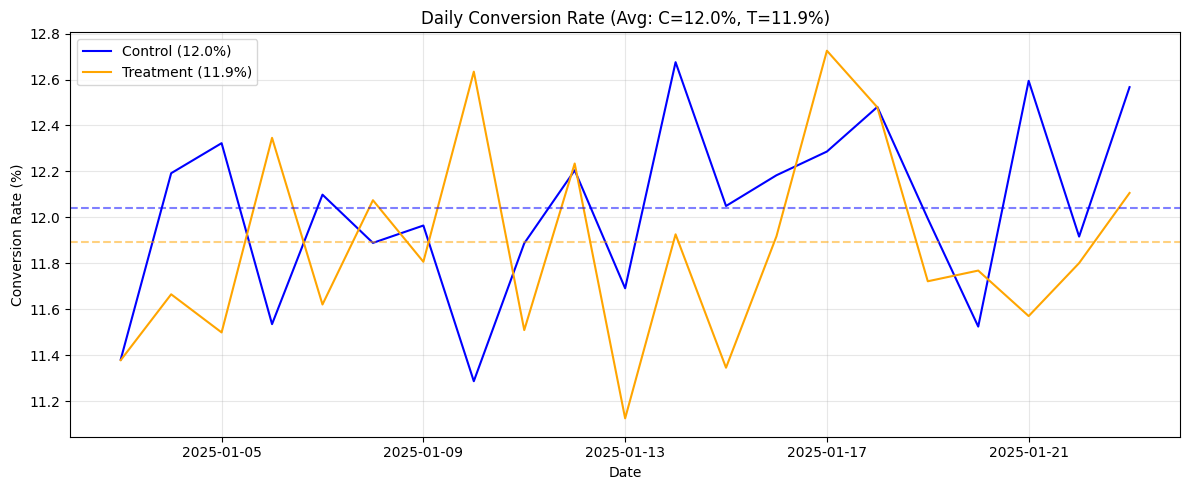

In [13]:
control = df_filtred[df_filtred['group']=='control'].groupby('date')['converted'].mean() * 100
treatment = df_filtred[df_filtred['group']=='treatment'].groupby('date')['converted'].mean() * 100
control_mean = df[df['group']=='control']['converted'].mean() * 100
treatment_mean = df[df['group']=='treatment']['converted'].mean() * 100

plt.figure(figsize=(12, 5))
plt.plot(control.index, control.values, label=f'Control ({control_mean:.1f}%)', color='blue')
plt.plot(treatment.index, treatment.values, label=f'Treatment ({treatment_mean:.1f}%)', color='orange')

plt.axhline(y=control_mean, color='blue', linestyle='--', alpha=0.5)
plt.axhline(y=treatment_mean, color='orange', linestyle='--', alpha=0.5)
plt.title(f'Daily Conversion Rate (Avg: C={control_mean:.1f}%, T={treatment_mean:.1f}%)')
plt.xlabel('Date')
plt.ylabel('Conversion Rate (%)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [19]:
df_filtred[df_filtred['group']=='control'].groupby('hour')['converted'].sum()

hour
0     670
1     691
2     659
3     640
4     705
5     727
6     731
7     703
8     685
9     722
10    684
11    738
12    711
13    667
14    689
15    685
16    709
17    714
18    726
19    659
20    673
21    681
22    688
23    730
Name: converted, dtype: int64

In [20]:
(0.12*0.88)**0.5/(700/0.12)

5.570769191750373e-05

C:\Users\frrrr\AppData\Local\Temp\ipykernel_17900\4184670314.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtred['hour'] = pd.to_datetime(df_filtred['timestamp']).dt.hour


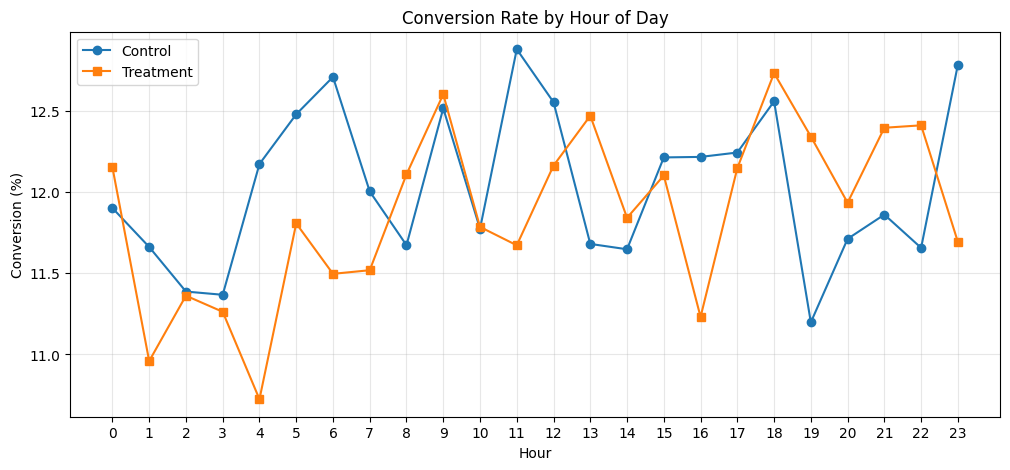

In [16]:
df_filtred['hour'] = pd.to_datetime(df_filtred['timestamp']).dt.hour

control_hourly = df_filtred[df_filtred['group']=='control'].groupby('hour')['converted'].mean() * 100
treatment_hourly = df_filtred[df_filtred['group']=='treatment'].groupby('hour')['converted'].mean() * 100
plt.figure(figsize=(12, 5))
plt.plot(control_hourly.index, control_hourly.values, label='Control', marker='o')
plt.plot(treatment_hourly.index, treatment_hourly.values, label='Treatment', marker='s')
plt.xlabel('Hour')
plt.ylabel('Conversion (%)')
plt.title('Conversion Rate by Hour of Day')
plt.xticks(range(0, 24))
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

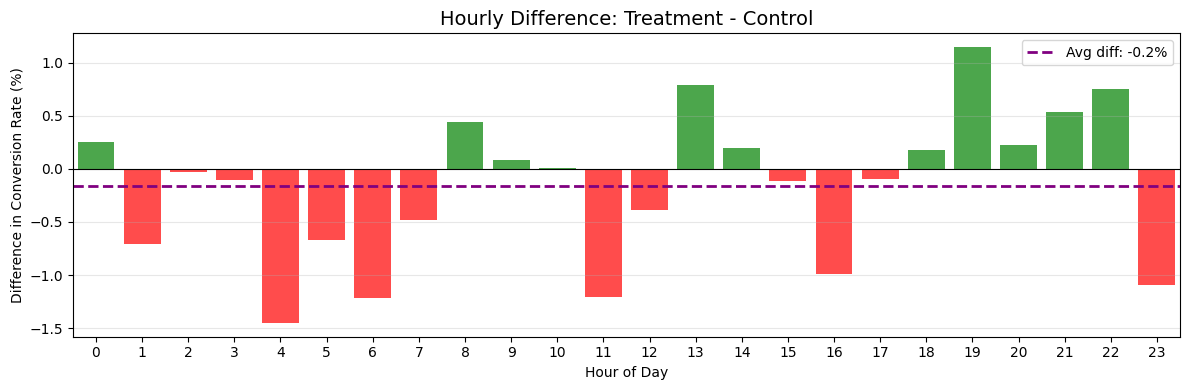

In [ ]:
hourly_diff = treatment_hourly - control_hourly
avg_hourly_diff = hourly_diff.mean()

plt.figure(figsize=(12, 4))

colors = ['green' if x > 0 else 'red' for x in hourly_diff]
plt.bar(range(24), hourly_diff.values, color=colors, alpha=0.7)

plt.axhline(y=avg_hourly_diff, color='purple', linestyle='--', linewidth=2, 
            label=f'Avg diff: {avg_hourly_diff:+.1f}%')
plt.axhline(y=0, color='black', linewidth=0.8)

plt.title(f'Hourly Difference: Treatment - Control', fontsize=14)
plt.xlabel('Hour of Day')
plt.ylabel('Difference in Conversion Rate (%)')
plt.xticks(range(0, 24))
plt.xlim(-0.5, 23.5)
plt.grid(True, alpha=0.3, axis='y')
plt.legend()
plt.tight_layout()

plt.show()

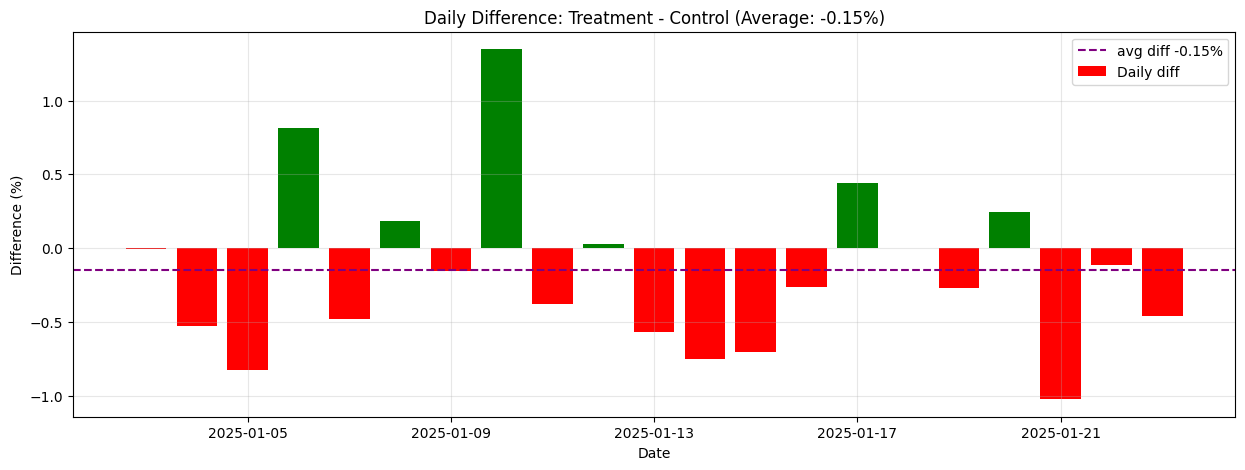

In [15]:
diff = treatment - control
avg_diff = treatment_mean - control_mean
diff


plt.figure(figsize=(15, 5))
colors = ['green' if x > 0 else 'red' for x in diff]
plt.bar(diff.index, diff.values, color=colors, label='Daily diff')
plt.axhline(avg_diff, color='purple', linestyle='--', label=f'avg diff {avg_diff:+.2f}%')
plt.title(f'Daily Difference: Treatment - Control (Average: {avg_diff:+.2f}%)')
plt.xlabel('Date')
plt.grid(True, alpha=0.3)
plt.ylabel('Difference (%)')
plt.legend()

plt.show() 

Несмотря на локальное расхождение в отдельный день, динамика до и после остаётся синхронной, а средние значения по периоду практически совпадают. Это указывает на отсутствие устойчивого эффекта и на случайный характер отклонения.

Если бы эффект был связан с версией лендинга, мы бы ожидали повторяемости или накопления эффекта во времени. Поскольку расхождение наблюдается только в одном дне и не подтверждается агрегированными метриками и статистическим тестом, мы не интерпретируем его как эффект.

Этот график используется как диагностический инструмент. Окончательный вывод о превосходстве одной из версий делается на основе агрегированного статистического теста по всем пользователям, а не по отдельным дням.

После проверки корректности данных и отсутствия временных искажений, следующим шагом была валидация процедуры эксперимента с помощью A/A теста.

In [25]:
control_df = df[df['group'] == 'control'].copy()

np.random.seed(42)
control_df['fake_group'] = np.random.choice(['A1', 'A2'], size=len(control_df))

print("Размеры групп:")
print(control_df['fake_group'].value_counts())

Размеры групп:
fake_group
A2    73660
A1    73542
Name: count, dtype: int64


In [26]:
conv_A1 = control_df[control_df['fake_group'] == 'A1']['converted'].mean()
conv_A2 = control_df[control_df['fake_group'] == 'A2']['converted'].mean()

print(f"Конверсия A: {conv_A1} ({conv_A1*100:.2f}%)")
print(f"Конверсия B: {conv_A2} ({conv_A2*100:.2f}%)")

Конверсия A: 0.12036659323923744 (12.04%)
Конверсия B: 0.12043171327721966 (12.04%)


In [27]:
from statsmodels.stats.proportion import proportions_ztest

success_A1 = control_df[control_df['fake_group'] == 'A1']['converted'].sum()
success_A2 = control_df[control_df['fake_group'] == 'A2']['converted'].sum()
n_A1 = len(control_df[control_df['fake_group'] == 'A1'])
n_A2 = len(control_df[control_df['fake_group'] == 'A2'])

z_stat, p_value = proportions_ztest([success_A1, success_A2], [n_A1, n_A2])

print(z_stat, p_value)

-0.0383872312551294 0.9693789414616656


A/A тест был проведён на контрольной группе, которая была случайно разделена на две подгруппы.
Полученное p-value оказалось больше 0.05, что означает отсутствие статистически значимых различий.
Это подтверждает корректность рандомизации и применяемого статистического теста.

H0: Конверсия пользователей в контрольной и тестовой группах одинакова

H1: Конверсия пользователей в контрольной и тестовой группах различается

In [28]:
success_A = df_filtred[df_filtred['group'] == 'control']['converted'].sum()
success_B = df_filtred[df_filtred['group'] == 'treatment']['converted'].sum()
n_A = len(df_filtred[df_filtred['group'] == 'treatment'])
n_B = len(df_filtred[df_filtred['group'] == 'treatment'])

z_stat, p_value = proportions_ztest([success_A, success_B], [n_A, n_B])

print(z_stat, p_value)

1.2465088620998173 0.21257763774453886


In [30]:
(success_A/n_A - success_B/n_B) * 100

np.float64(0.1534847524067559)

По результатам двухвыборочного z-теста p-value > 0.05, поэтому нулевая гипотеза не отвергается. Статистически значимых различий в конверсии между версиями лендинга не обнаружено.

In [48]:
control = df_filtred[df_filtred['group']=='control']['converted'].values
treatment = df_filtred[df_filtred['group']=='treatment']['converted'].values
diffs = []
for _ in range(10000):
    sample_control = np.random.choice(control, size=len(control), replace=True)
    sample_treatment = np.random.choice(treatment, size=len(treatment), replace=True)
    diffs.append(sample_treatment.mean() - sample_control.mean())
diffs = np.array(diffs)
print("Mean diffs:", diffs.mean())
print("2.5 percentile:", np.percentile(diffs, 2.5))
print("97.5 percentile:", np.percentile(diffs, 97.5))

Mean diffs: -0.0016458792860513981
2.5 percentile: -0.004035166209704035
97.5 percentile: 0.0007234195998672966


В бутстрап-анализе средняя разница конверсий составила −0.16%. При этом основной диапазон значений находится между −0.40% и +0.07%, включая нулевую разницу. Это указывает на отсутствие устойчивого эффекта и подтверждает результат A/B теста.

In [23]:
df_filtred['hour'] = pd.to_datetime(df['timestamp']).dt.hour

C:\Users\frrrr\AppData\Local\Temp\ipykernel_10040\3627322088.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtred['hour'] = pd.to_datetime(df['timestamp']).dt.hour


In [24]:
def assign_window(hour):
    if 0 <= hour <= 7:
        return 'w1_0_8'
    elif 8 <= hour <= 15:
        return 'w2_8_16'
    else:
        return 'w3_16_24'

df_filtred['window'] = df_filtred['hour'].apply(assign_window)

C:\Users\frrrr\AppData\Local\Temp\ipykernel_10040\3114003433.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtred['window'] = df_filtred['hour'].apply(assign_window)


In [25]:
df_filtred['window'].value_counts()

window
w3_16_24    92662
w1_0_8      92444
w2_8_16     92331
Name: count, dtype: int64

In [42]:
df_w_windows = df_filtred.groupby(['date','window','group']).agg(successes=('converted','sum'), users=('converted','count')).reset_index()
df_w_windows

,date,window,group,successes,users
0,2025-01-03,w1_0_8,control,259,2272
1,2025-01-03,w1_0_8,treatment,253,2214
2,2025-01-03,w2_8_16,control,251,2118
3,2025-01-03,w2_8_16,treatment,256,2175
4,2025-01-03,w3_16_24,control,240,2200
...,...,...,...,...,...
121,2025-01-23,w1_0_8,treatment,278,2280
122,2025-01-23,w2_8_16,control,285,2257
123,2025-01-23,w2_8_16,treatment,265,2174
124,2025-01-23,w3_16_24,control,277,2210


In [44]:
pivot = df_w_windows.pivot_table(index='date', columns=['window','group'], values=['successes','users'])
pivot

successes                                                  users  \
window        w1_0_8           w2_8_16           w3_16_24            w1_0_8   
group        control treatment control treatment  control treatment control   
date                                                                          
2025-01-03     259.0     253.0   251.0     256.0    240.0     244.0  2272.0   
2025-01-04     256.0     220.0   273.0     271.0    273.0     272.0  2179.0   
2025-01-05     260.0     236.0   260.0     260.0    272.0     252.0  2178.0   
2025-01-06     243.0     284.0   246.0     264.0    273.0     285.0  2199.0   
2025-01-07     267.0     244.0   276.0     277.0    256.0     247.0  2234.0   
2025-01-08     272.0     273.0   265.0     273.0    258.0     263.0  2134.0   
2025-01-09     274.0     259.0   232.0     263.0    287.0     259.0  2220.0   
2025-01-10     264.0     258.0   256.0     288.0    231.0     300.0  2247.0   
2025-01-11     255.0     243.0   269.0     260.0    271.0     265.0  2205.0   
2025-01-12     265.0     253.0   290.0     279.0    241.0     280.0  2198.0   
2025-01-13     264.0     244.0   240.0     242.0    262.0     238.0  2161.0   
2025-01-14     279.0     260.0   263.0     262.0    288.0     265.0  2176.0   
2025-01-15     262.0     244.0   271.0     254.0    276.0     245.0  2196.0   
2025-01-16     259.0     239.0   258.0     270.0    286.0     271.0  2195.0   
2025-01-17     285.0     273.0   274.0     269.0    254.0     290.0  2203.0   
2025-01-18     234.0     268.0   296.0     293.0    279.0     263.0  2094.0   
2025-01-19     258.0     238.0   268.0     261.0    263.0     269.0  2217.0   
2025-01-20     263.0     233.0   241.0     258.0    249.0     295.0  2176.0   
2025-01-21     282.0     230.0   291.0     254.0    277.0     275.0  2286.0   
2025-01-22     243.0     248.0   276.0     275.0    267.0     264.0  2175.0   
2025-01-23     282.0     278.0   285.0     265.0    277.0     260.0  2249.0   

                                                           
window               w2_8_16           w3_16_24            
group      treatment control treatment  control treatment  
date                                                       
2025-01-03    2214.0  2118.0    2175.0   2200.0    2229.0  
2025-01-04    2168.0  2179.0    2166.0   2220.0    2207.0  
2025-01-05    2171.0  2153.0    2169.0   2096.0    2165.0  
2025-01-06    2307.0  2188.0    2201.0   2219.0    2239.0  
2025-01-07    2207.0  2204.0    2170.0   2166.0    2232.0  
2025-01-08    2202.0  2261.0    2234.0   2292.0    2264.0  
2025-01-09    2183.0  2144.0    2230.0   2264.0    2202.0  
2025-01-10    2251.0  2232.0    2267.0   2175.0    2178.0  
2025-01-11    2171.0  2268.0    2237.0   2215.0    2265.0  
2025-01-12    2179.0  2159.0    2246.0   2165.0    2212.0  
2025-01-13    2185.0  2191.0    2182.0   2200.0    2141.0  
2025-01-14    2167.0  2112.0    2224.0   2260.0    2208.0  
2025-01-15    2219.0  2185.0    2144.0   2333.0    2186.0  
2025-01-16    2152.0  2162.0    2240.0   2234.0    2153.0  
2025-01-17    2174.0  2321.0    2114.0   2093.0    2250.0  
2025-01-18    2207.0  2147.0    2239.0   2241.0    2157.0  
2025-01-19    2212.0  2155.0    2173.0   2206.0    2167.0  
2025-01-20    2206.0  2197.0    2232.0   2161.0    2241.0  
2025-01-21    2180.0  2239.0    2170.0   2224.0    2210.0  
2025-01-22    2215.0  2198.0    2274.0   2223.0    2180.0  
2025-01-23    2280.0  2257.0    2174.0   2210.0    2179.0

In [45]:
pivot.columns = ['{}_{}_{}'.format(x[0], x[1], x[2]) for x in pivot.columns]
pivot

,successes_w1_0_8_control,successes_w1_0_8_treatment,successes_w2_8_16_control,successes_w2_8_16_treatment,successes_w3_16_24_control,successes_w3_16_24_treatment,users_w1_0_8_control,users_w1_0_8_treatment,users_w2_8_16_control,users_w2_8_16_treatment,users_w3_16_24_control,users_w3_16_24_treatment
date,,,,,,,,,,,,
2025-01-03,259.0,253.0,251.0,256.0,240.0,244.0,2272.0,2214.0,2118.0,2175.0,2200.0,2229.0
2025-01-04,256.0,220.0,273.0,271.0,273.0,272.0,2179.0,2168.0,2179.0,2166.0,2220.0,2207.0
2025-01-05,260.0,236.0,260.0,260.0,272.0,252.0,2178.0,2171.0,2153.0,2169.0,2096.0,2165.0
2025-01-06,243.0,284.0,246.0,264.0,273.0,285.0,2199.0,2307.0,2188.0,2201.0,2219.0,2239.0
2025-01-07,267.0,244.0,276.0,277.0,256.0,247.0,2234.0,2207.0,2204.0,2170.0,2166.0,2232.0
2025-01-08,272.0,273.0,265.0,273.0,258.0,263.0,2134.0,2202.0,2261.0,2234.0,2292.0,2264.0
2025-01-09,274.0,259.0,232.0,263.0,287.0,259.0,2220.0,2183.0,2144.0,2230.0,2264.0,2202.0
2025-01-10,264.0,258.0,256.0,288.0,231.0,300.0,2247.0,2251.0,2232.0,2267.0,2175.0,2178.0
2025-01-11,255.0,243.0,269.0,260.0,271.0,265.0,2205.0,2171.0,2268.0,2237.0,2215.0,2265.0


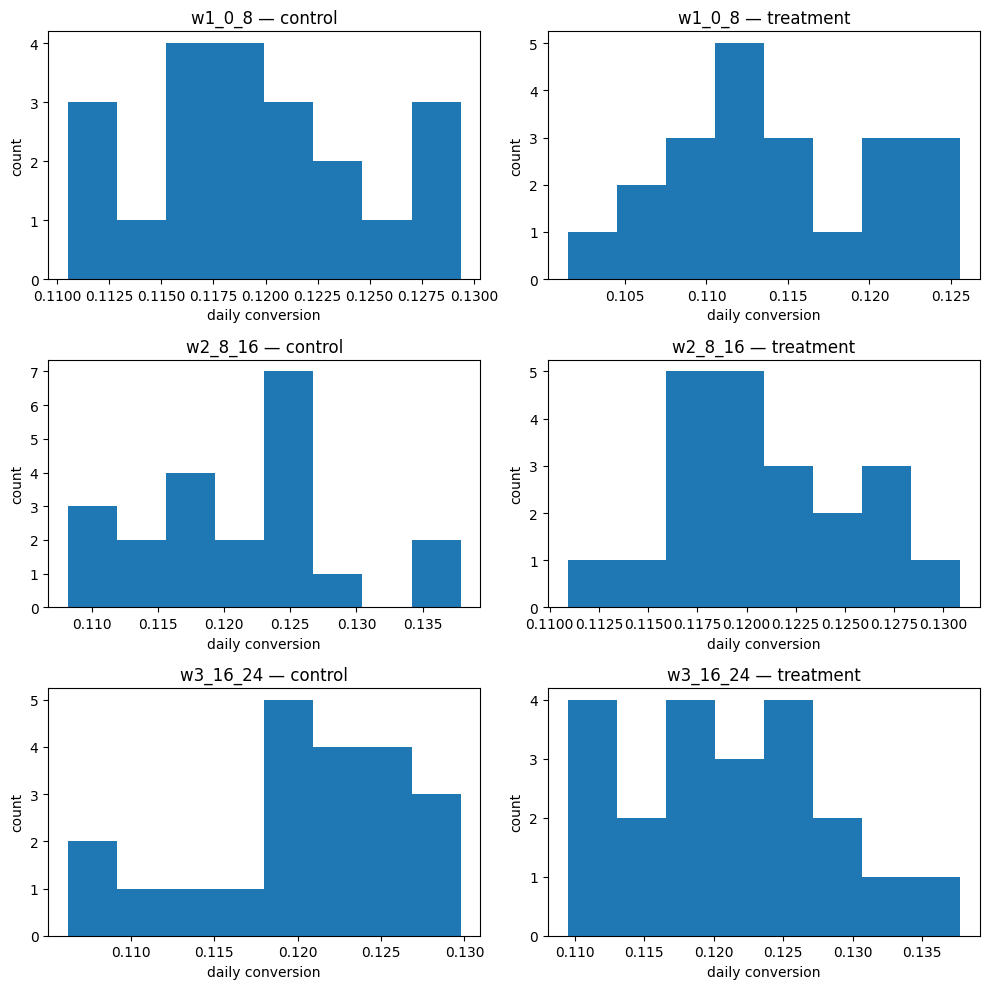

In [46]:
df_w_windows_means = df_filtred.groupby(['date', 'window', 'group'])['converted'].mean().reset_index()

windows = ['w1_0_8', 'w2_8_16', 'w3_16_24']
groups = ['control', 'treatment']

fig, axes = plt.subplots(3, 2, figsize=(10, 10))

for i, w in enumerate(windows):
    for j, g in enumerate(groups):
        data = df_w_windows_means[(df_w_windows_means['window'] == w) & (df_w_windows_means['group'] == g)]['converted']
        
        axes[i, j].hist(data, bins=8)
        axes[i, j].set_title(f'{w} — {g}')
        axes[i, j].set_xlabel('daily conversion')
        axes[i, j].set_ylabel('count')

plt.tight_layout()
plt.show()


In [51]:
df_w_windows_means

,date,window,group,converted
0,2025-01-03,w1_0_8,control,0.113996
1,2025-01-03,w1_0_8,treatment,0.114273
2,2025-01-03,w2_8_16,control,0.118508
3,2025-01-03,w2_8_16,treatment,0.117701
4,2025-01-03,w3_16_24,control,0.109091
...,...,...,...,...
121,2025-01-23,w1_0_8,treatment,0.121930
122,2025-01-23,w2_8_16,control,0.126274
123,2025-01-23,w2_8_16,treatment,0.121895
124,2025-01-23,w3_16_24,control,0.125339


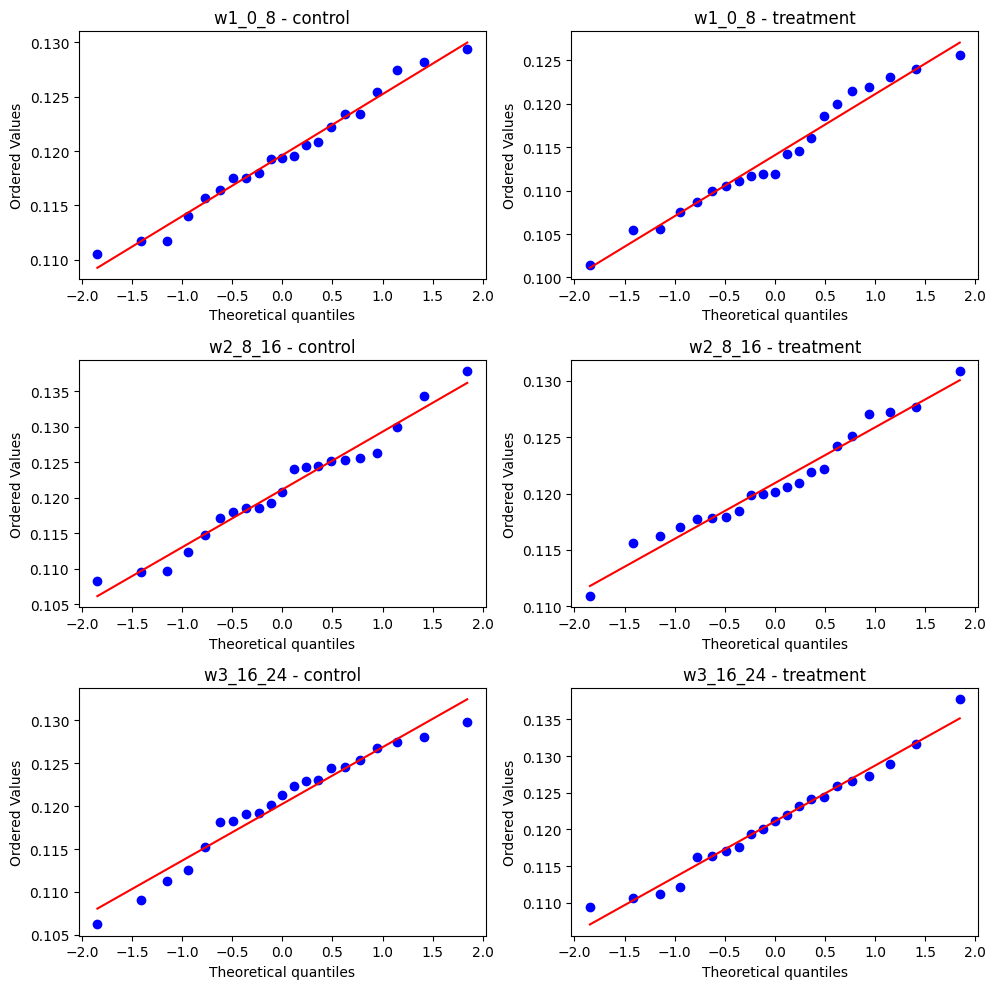

In [48]:
fig, axes = plt.subplots(3, 2, figsize=(10, 10))

for i, w in enumerate(windows):
    for j, g in enumerate(groups):
        data = df_w_windows_means[(df_w_windows_means['window'] == w) & (df_w_windows_means['group'] == g)]['converted']

        stats.probplot(data, dist="norm", plot=axes[i, j])
        axes[i, j].set_title(f'{w} - {g}')

plt.tight_layout()
plt.show()


Мы визуально проверили распределения дневной конверсии с помощью QQ-плотов; они не показывают сильных отклонений от нормальности, поэтому применение t-теста допустимо.

In [52]:
results = []
windows = ['w1_0_8','w2_8_16','w3_16_24']
for w in windows:
    s_control = pivot[f'successes_{w}_control']
    n_control = pivot[f'users_{w}_control']
    s_treat   = pivot[f'successes_{w}_treatment']
    n_treat   = pivot[f'users_{w}_treatment']

    rate_c = (s_control / n_control).values
    rate_t = (s_treat / n_treat).values
    ndays = len(rate_c)

    stat, p = ttest_rel(rate_t, rate_c)
    test_name = 'paired t-test'
    results.append({'window': w, 'pval': p})
pd.DataFrame(results)

,window,pval
0,w1_0_8,0.002741
1,w2_8_16,0.869789
2,w3_16_24,0.718836
